# Feature Embedding for User and Article

The goal is to generate feature embedding for each user and article. \
The preliminary embedding will be only based on article sets, later we will include other feaures unique to user and article.

In [2]:
import pandas as pd
import pyarrow as pa
from collections import defaultdict
import numpy as np
import torch

In [3]:
# Read parquet files
df_articles = pd.read_parquet('ebnerd_demo/articles.parquet')
df_behaviors = pd.read_parquet('ebnerd_demo/train/behaviors.parquet')
df_history = pd.read_parquet('ebnerd_demo/train/history.parquet')

In [4]:
df_behaviors

impression_id  article_id     impression_time  read_time  \
0              48401         NaN 2023-05-21 21:06:50       21.0   
1             152513   9778745.0 2023-05-24 07:31:26       30.0   
2             155390         NaN 2023-05-24 07:30:33       45.0   
3             214679         NaN 2023-05-23 05:25:40       33.0   
4             214681         NaN 2023-05-23 05:31:54       21.0   
...              ...         ...                 ...        ...   
24719      579983230         NaN 2023-05-22 08:30:52       35.0   
24720      579983231         NaN 2023-05-22 08:31:34       89.0   
24721      579984721   9774541.0 2023-05-22 08:51:33      123.0   
24722      579984723   9775699.0 2023-05-22 08:53:36       73.0   
24723      580097289   9770541.0 2023-05-18 10:56:49      107.0   

       scroll_percentage  device_type  \
0                    NaN            2   
1                  100.0            1   
2                    NaN            1   
3                    NaN            2   
4                    NaN            2   
...                  ...          ...   
24719                NaN            1   
24720                NaN            1   
24721              100.0            2   
24722              100.0            2   
24723              100.0            1   

                                      article_ids_inview article_ids_clicked  \
0      [9774516, 9771051, 9770028, 9775402, 9774461, ...           [9759966]   
1      [9778669, 9778736, 9778623, 9089120, 9778661, ...           [9778661]   
2      [9778369, 9777856, 9778500, 9778021, 9778627, ...           [9777856]   
3      [9776715, 9776406, 9776566, 9776071, 9776808, ...           [9776566]   
4      [9775202, 9776855, 9776688, 9771995, 9776583, ...           [9776553]   
...                                                  ...                 ...   
24719  [9775562, 9775701, 9486486, 9353420, 9775621, ...           [9775562]   
24720  [9775347, 9678300, 9754160, 9770028, 9775500, ...           [9775361]   
24721      [9775699, 9775722, 9774541, 9775648, 9775325]           [9775699]   
24722  [9772221, 9758424, 9775699, 9775722, 9775621, ...           [9758424]   
24723  [9657528, 9769356, 9746428, 9771237, 9770369, ...           [9770369]   

       user_id  is_sso_user  gender  postcode  age  is_subscriber  session_id  \
0        22779        False     NaN       NaN  NaN          False          21   
1       150224        False     NaN       NaN  NaN          False         298   
2       160892        False     NaN       NaN  NaN          False         401   
3      1001055        False     NaN       NaN  NaN          False        1357   
4      1001055        False     NaN       NaN  NaN          False        1358   
...        ...          ...     ...       ...  ...            ...         ...   
24719  2053999        False     NaN       NaN  NaN          False      170832   
24720  2053999        False     NaN       NaN  NaN          False      170832   
24721  2060487        False     NaN       NaN  NaN          False      107303   
24722  2060487        False     NaN       NaN  NaN          False      107303   
24723  2096611        False     NaN       NaN  NaN          False       73638   

       next_read_time  next_scroll_percentage  
0                16.0                    27.0  
1                 2.0                    48.0  
2               215.0                   100.0  
3                40.0                    47.0  
4                 5.0                    49.0  
...               ...                     ...  
24719             7.0                    28.0  
24720             0.0                     NaN  
24721            73.0                   100.0  
24722           101.0                   100.0  
24723            73.0                     7.0  

[24724 rows x 17 columns]

### User Embedding

In [5]:
# aliasing for easier access
behaviors = df_behaviors

In [6]:
# switch the order within the list so that the first element is the selected
def reorder_set(row):
    # Extract the set and clicked elements
    set_list = list(row['article_ids_inview'])
    clicked_item = row['article_ids_clicked']

    # Find index of clicked_item, if it exists in set_list
    try:
        index = set_list.index(clicked_item)  # This will raise ValueError if not found
        # Move clicked_item to the front
        set_list.insert(0, set_list.pop(index))
    except ValueError:
        # Handle the case where clicked_item is not in set_list
        pass

    return set_list

# Apply the function to each row
behaviors['article_ids_inview'] = behaviors.apply(reorder_set, axis=1)

In [7]:
# add readtime and scroll percentage to the end
def append_value(row):
    # Extract the 'clicked' value; if NaN, use 0
    clicked_value = 0 if pd.isna(row['read_time']) else row['read_time']
    # Extract the 'some_value' value; if NaN, use 0
    some_value = 0 if pd.isna(row['scroll_percentage']) else row['scroll_percentage']

    # Append both values to the list
    return row['article_ids_inview'] + [clicked_value, some_value]

# Apply the function to each row
behaviors['new_sets'] = behaviors.apply(append_value, axis=1)

In [8]:
# Group by 'user_id' and aggregate 'set' into a list of lists
behavior_grouped = behaviors.groupby('user_id')['new_sets'].agg(lambda x: list(x)).reset_index()

In [9]:
# Function to convert list of lists to DataFrame
def list_of_lists_to_df(list_of_lists):
    return pd.DataFrame(list_of_lists)

# Apply the function to convert each 'set' into a DataFrame (matrix)
behavior_grouped['final_matrix'] = behavior_grouped['new_sets'].apply(list_of_lists_to_df)

In [10]:
behavior_grouped["matrix_transpose"] = behavior_grouped["final_matrix"].apply(lambda x: x.T)

In [11]:
user_label = behavior_grouped[["user_id", "matrix_transpose"]]

### Article Embedding

In [12]:
# aliasing for easier access
behavior = df_behaviors

In [13]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24724 entries, 0 to 24723
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   impression_id           24724 non-null  uint32        
 1   article_id              7378 non-null   float64       
 2   impression_time         24724 non-null  datetime64[us]
 3   read_time               24724 non-null  float32       
 4   scroll_percentage       7242 non-null   float32       
 5   device_type             24724 non-null  int8          
 6   article_ids_inview      24724 non-null  object        
 7   article_ids_clicked     24724 non-null  object        
 8   user_id                 24724 non-null  uint32        
 9   is_sso_user             24724 non-null  bool          
 10  gender                  1797 non-null   float64       
 11  postcode                361 non-null    float64       
 12  age                     617 non-null    float6

In [14]:
# concatenate article_ids_inview, read_time, and scroll_percentage
def concatenate_row(row):
    return np.concatenate([row['article_ids_inview'], [row['read_time'], row['scroll_percentage']]])

# Apply function across rows
behavior['complete_set'] = behavior.apply(concatenate_row, axis=1)

In [15]:
# empty dictionary holding the result
article_dict = defaultdict(list)

# Iterate through each row of the DataFrame
for index, row in behavior.iterrows():
    article_list = row['article_ids_inview']
    clicked = row['article_ids_clicked']
    new_set = row['complete_set'].copy()  # Make a copy to avoid modifying the original list

    # Process each article in the view list
    for article in article_list:
        if article == clicked[0]:
            # Prepend a 1 to the new set list if this article was clicked
            modified_set = np.concatenate([[1], new_set])
        else:
            # Use the new set list as is
            modified_set = np.concatenate([[0], new_set])

        # Append the modified new set list to the dictionary under the article key
        article_dict[article].append(modified_set)

# Convert the defaultdict to a regular dictionary for final output if necessary
article_dict = dict(article_dict)

# Display the resulting dictionary
# print(article_dict)


In [16]:
#article_dict[9614318]

In [17]:
import numpy as np
import pandas as pd

def pad_array(arr, target_length, pad_value=np.nan):
    """Pad an array to the target length with the specified pad value."""
    return np.concatenate((arr, np.full((target_length - len(arr),), pad_value)))

# Determine the maximum length of arrays in all lists
max_length = max(len(item) for sublist in article_dict.values() for item in sublist)

# Pad the arrays and create the DataFrame
data = []
for article_id, arrays in article_dict.items():
    padded_arrays = [pad_array(array, max_length) for array in arrays]
    # Optionally, you could concatenate these into a single array here
    final_matrix = np.stack(padded_arrays)  # Stacks arrays along a new axis, creating a 2D matrix per ID
    data.append([article_id, final_matrix])

# Create DataFrame
df = pd.DataFrame(data, columns=['article_id', 'final_matrix'])

# Display the DataFrame
# print(df)

In [18]:
# Find the row where article_id is 9614318
#df.columns

In [19]:
df["matrix_transpose"] = df["final_matrix"].apply(lambda x: x.T)

In [20]:
import pandas as pd
import networkx as nx


# Create an empty directed graph
G = nx.DiGraph()

# Add article nodes
article_ids = df_articles['article_id'].unique()
G.add_nodes_from(article_ids, node_type='article')

# Add user nodes
user_ids = df_history['user_id'].unique()
G.add_nodes_from(user_ids, node_type='user')

# Add directed edges from users to clicked articles
for _, row in df_behaviors.iterrows():
    user_id = row['user_id']
    clicked_articles = row['article_ids_clicked']

    # Add directed edges from user to clicked articles
    for article_id in clicked_articles:
        G.add_edge(user_id, article_id)

# Print the number of nodes and edges in the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 13367
Number of edges: 24414


In [21]:
import pandas as pd
import networkx as nx

# Count article nodes and user nodes
article_nodes = [node for node in G.nodes() if G.nodes[node]['node_type'] == 'article']
user_nodes = [node for node in G.nodes() if G.nodes[node]['node_type'] == 'user']

print("Number of article nodes:", len(article_nodes))
print("Number of user nodes:", len(user_nodes))

Number of article nodes: 11777
Number of user nodes: 1590


In [22]:
article_label = df[["article_id", "matrix_transpose"]]

In [23]:
# Zip the article_ids with their corresponding transposed matrices into a dictionary
article_label_dict = dict(zip(article_label["article_id"], article_label["matrix_transpose"]))
user_label_dict = dict(zip(user_label["user_id"], user_label["matrix_transpose"]))

In [24]:
article_label_dict

{9759966: array([[1.000000e+00, 0.000000e+00, 1.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [9.759966e+06, 9.775323e+06, 9.759966e+06, ..., 9.771168e+06,
         9.767336e+06, 9.775142e+06],
        [9.774516e+06, 9.774461e+06, 9.775331e+06, ..., 9.384788e+06,
         9.775903e+06, 9.775323e+06],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]),
 9774516: array([[      0.,       0.,       0., ...,       0.,       0.,       0.],
        [9759966., 9775323., 9759966., ..., 9775256., 9774557., 9760046.],
        [9774516., 9774461., 9775331., ..., 9664250., 9538375., 9538375.],
        ...,
        [     nan,      nan,      nan, ...,      nan,      nan,      nan],
      

In [25]:
user_label_dict

{11313:             0          1          2          3          4          5  \
 0   9776897.0  9779860.0  9778627.0  9776855.0  9776715.0  9778701.0   
 1   9776968.0  9780193.0  9778682.0  9776864.0  9776046.0  9778669.0   
 2   9776917.0  9779577.0  9778444.0  9776870.0  9775985.0  9778444.0   
 3   9777036.0  9779713.0  9777492.0  9776287.0  9776566.0  9778718.0   
 4   9777005.0  9779777.0  9778628.0  9776882.0  9776246.0  9778682.0   
 5   9776916.0  9779648.0  9778657.0        4.0  9776406.0  9778657.0   
 6        11.0  9779427.0  9778623.0        0.0  9776855.0  9778623.0   
 7         0.0  9779205.0  9778669.0        NaN  9776862.0  9778661.0   
 8         NaN  9779263.0       51.0        NaN  9759955.0  9777397.0   
 9         NaN  9780181.0      100.0        NaN  9776071.0        9.0   
 10        NaN  9766434.0        NaN        NaN  9776864.0        0.0   
 11        NaN       21.0        NaN        NaN  9776287.0        NaN   
 12        NaN        0.0        NaN        

In [36]:
# concatenate article_ids_inview, read_time, and scroll_percentage
def concatenate_row(row):
    return np.concatenate([row['article_ids_inview'],  row['user_id'],[row['read_time'], row['scroll_percentage']]])

# Apply function across rows
behaviors['complete_set'] = behaviors.apply(concatenate_row, axis=1)

# empty dictionary holding the result
article_dict = defaultdict(list)

# Iterate through each row of the DataFrame
for index, row in behaviors.iterrows():
    article_list = row['article_ids_inview']
    clicked = row['article_ids_clicked']
    new_set = row['complete_set'].copy() # Make a copy to avoid modifying the original list
    
    # Process each article in the view list
    for article in article_list:
        if article == clicked[0]:
            # Prepend a 1 to the new set list if this article was clicked
            modified_set = np.concatenate([[1], new_set])
        else:
            # Use the new set list as is
            modified_set = np.concatenate([[0], new_set])
        
        # Append the modified new set list to the dictionary under the article key
        article_dict[article].append(modified_set)

# Convert the defaultdict to a regular dictionary for final output if necessary
article_dict = dict(article_dict)

def pad_array(arr, target_length, pad_value=np.nan):
    """Pad an array to the target length with the specified pad value."""
    return np.concatenate((arr, np.full((target_length - len(arr),), pad_value)))

# Determine the maximum length of arrays in all lists
max_length = max(len(item) for sublist in article_dict.values() for item in sublist)

# Pad the arrays and create the DataFrame
data = []
for article_id, arrays in article_dict.items():
    padded_arrays = [pad_array(array, max_length) for array in arrays]
    # Optionally, you could concatenate these into a single array here
    final_matrix = np.stack(padded_arrays) # Stacks arrays along a new axis, creating a 2D matrix per ID
    data.append([article_id, final_matrix])

In [37]:
# Create DataFrame
df = pd.DataFrame(data, columns=['article_id', 'final_matrix'])
df["matrix_transpose"] = df["final_matrix"].apply(lambda x: x.T)

# Create an empty directed graph
G = nx.DiGraph()

# Add article nodes
article_ids = df_articles['article_id'].unique()
G.add_nodes_from(article_ids, node_type='article')

# Add user nodes
user_ids = df_behaviors['user_id'].unique()
G.add_nodes_from(user_ids, node_type='user')

# Add directed edges from users to clicked articles
for _, row in df_behaviors.iterrows():
    user_id = row['user_id']
    clicked_articles = row['article_ids_clicked']
    # Add directed edges from user to clicked articles
    for article_id in clicked_articles:
        G.add_edge(user_id, article_id)

article_label = df[["article_id", "matrix_transpose"]]
# Zip the article_ids with their corresponding transposed matrices into a dictionary
article_label_dict = dict(zip(article_label["article_id"], article_label["matrix_transpose"]))
user_label_dict = dict(zip(user_label["user_id"], user_label["matrix_transpose"]))

print("df_articles columns:")
print(df_articles[['category', 'subcategory', 'sentiment_score', 'sentiment_label']].info())
print("\ndf_behaviors columns:")
print(df_behaviors[['gender', 'age', 'is_subscriber']].info())

# Extract additional article features
article_features_dict = {
    article_id: [
        category.tolist()[0] if isinstance(category, np.ndarray) and category.size > 0 and not pd.isna(category.tolist()[0]) else None,
        subcategory.tolist()[0] if isinstance(subcategory, np.ndarray) and subcategory.size > 0 and not pd.isna(subcategory.tolist()[0]) else None,
        sentiment_score.tolist()[0] if isinstance(sentiment_score, np.ndarray) and sentiment_score.size > 0 and not pd.isna(sentiment_score.tolist()[0]) else None,
        sentiment_label.tolist()[0] if isinstance(sentiment_label, np.ndarray) and sentiment_label.size > 0 and not pd.isna(sentiment_label.tolist()[0]) else None
    ]
    for article_id, category, subcategory, sentiment_score, sentiment_label in
    zip(df_articles['article_id'], df_articles['category'], df_articles['subcategory'],
        df_articles['sentiment_score'], df_articles['sentiment_label'])
}

# Extract additional user features
user_features_dict = {
    user_id: [
        gender.tolist()[0] if isinstance(gender, np.ndarray) and 'gender' in df_behaviors.columns and gender.size > 0 and not pd.isna(gender.tolist()[0]) else None,
        age.tolist()[0] if isinstance(age, np.ndarray) and 'age' in df_behaviors.columns and age.size > 0 and not pd.isna(age.tolist()[0]) else None,
        is_subscriber.tolist()[0] if isinstance(is_subscriber, np.ndarray) and 'is_subscriber' in df_behaviors.columns and is_subscriber.size > 0 and not pd.isna(is_subscriber.tolist()[0]) else None
    ]
    for user_id, gender, age, is_subscriber in
    zip(df_behaviors['user_id'],
        df_behaviors['gender'] if 'gender' in df_behaviors.columns else [None] * len(df_behaviors),
        df_behaviors['age'] if 'age' in df_behaviors.columns else [None] * len(df_behaviors),
        df_behaviors['is_subscriber'] if 'is_subscriber' in df_behaviors.columns else [None] * len(df_behaviors))
}

# Count NA values in article features
article_feature_na_counts = {
    'category': sum(1 for x in article_features_dict.values() if x[0] is None),
    'subcategory': sum(1 for x in article_features_dict.values() if x[1] is None),
    'sentiment_score': sum(1 for x in article_features_dict.values() if x[2] is None),
    'sentiment_label': sum(1 for x in article_features_dict.values() if x[3] is None)
}

print("Article feature NA counts:")
print(article_feature_na_counts)

# Count NA values in user features
user_feature_na_counts = {
    'gender': sum(1 for x in user_features_dict.values() if x[0] is None),
    'age': sum(1 for x in user_features_dict.values() if x[1] is None),
    'is_subscriber': sum(1 for x in user_features_dict.values() if x[2] is None)
}
print("\nUser feature NA counts:")
print(user_feature_na_counts)

df_articles columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11777 entries, 0 to 11776
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         11777 non-null  int16  
 1   subcategory      11777 non-null  object 
 2   sentiment_score  11777 non-null  float32
 3   sentiment_label  11777 non-null  object 
dtypes: float32(1), int16(1), object(2)
memory usage: 253.2+ KB
None

df_behaviors columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24724 entries, 0 to 24723
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         1797 non-null   float64
 1   age            617 non-null    float64
 2   is_subscriber  24724 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 410.6 KB
None
Article feature NA counts:
{'category': 11777, 'subcategory': 3512, 'sentiment_score': 11777, 'sentiment_label': 11777}

In [31]:
# Compute the maximum number of features (columns) across both articles and users
max_columns = max(max([features.shape[1] for features in article_label_dict.values()]),
                  max([features.shape[1] for features in user_label_dict.values()]))

# The maximum number of rows is hardcoded to 103 based on your data
max_rows = 103

# Compute the maximum number of additional features across both articles and users
max_additional_features = max(
    max([len(features) for features in article_features_dict.values()]),
    max([len(features) for features in user_features_dict.values()])
)

# Initialize the tensors with NaNs to accommodate the maximum number of rows, columns, and additional features
padded_article_features = torch.full((len(article_label_dict), max_rows, max_columns + max_additional_features), float('nan'))
padded_user_features = torch.full((len(user_label_dict), max_rows, max_columns + max_additional_features), float('nan'))


# Pad article features
for i, (article_id, features) in enumerate(article_label_dict.items()):
    features_array = np.array(features)
    num_rows = min(features_array.shape[0], max_rows)
    num_columns = min(features_array.shape[1], max_columns)
    padded_features = np.full((max_rows, max_columns + max_additional_features), np.nan)
    padded_features[:num_rows, :num_columns] = features_array[:num_rows, :num_columns]
    
    # Append additional article features
    additional_features = article_features_dict[article_id]
    padded_features[:, max_columns:max_columns+len(additional_features)] = [
        feature if feature is not None else np.nan for feature in additional_features
    ]
    
    padded_article_features[i] = torch.from_numpy(padded_features)

# Pad user features similarly
for i, (user_id, features) in enumerate(user_label_dict.items()):
    features_array = np.array(features)
    num_rows = min(features_array.shape[0], max_rows)
    num_columns = min(features_array.shape[1], max_columns)
    padded_features = np.full((max_rows, max_columns + max_additional_features), np.nan)
    padded_features[:num_rows, :num_columns] = features_array[:num_rows, :num_columns]
    
    # Append additional user features if available
    if user_id in user_features_dict:
        additional_features = user_features_dict[user_id]
        padded_features[:, max_columns:max_columns+len(additional_features)] = [
            feature if feature is not None else np.nan for feature in additional_features
        ]
    
    padded_user_features[i] = torch.from_numpy(padded_features)

# Concatenate the padded features
node_features = torch.cat((padded_article_features, padded_user_features), dim=0)

In [39]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv, GATConv, SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import pandas as pd
import networkx as nx
from collections import defaultdict
import random
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume previous data loading and feature setting is done here...
feature_size = node_features.shape[2]  # Assuming node_features is defined
num_nodes = node_features.shape[0]


# Create mappings between user/article IDs and indices
user_to_index = {user_id: i for i, user_id in enumerate(user_ids)}
article_to_index = {article_id: i for i, article_id in enumerate(article_ids)}

# Prepare source and destination node lists for edges
edges_src = []
edges_dst = []
labels = []

# Create edges from users to clicked articles
for user_id in user_ids:
    user_idx = user_to_index[user_id]
    clicked_articles = set(df_behaviors[df_behaviors['user_id'] == user_id]['article_ids_clicked'].explode())
    
    for article_id in clicked_articles:
        article_idx = article_to_index[article_id]
        edges_src.append(user_idx)
        edges_dst.append(article_idx)
        labels.append(1)  # Positive label for clicked articles

# Create edges from users to non-clicked articles (negative sampling)
num_negative_samples = len(labels) * 5  # Adjust the ratio of negative samples as needed
negative_edges_src = []
negative_edges_dst = []
negative_labels = []

while len(negative_labels) < num_negative_samples:
    user_id = random.choice(user_ids)
    user_idx = user_to_index[user_id]
    article_id = random.choice(article_ids)
    article_idx = article_to_index[article_id]
    
    if article_id not in df_behaviors[df_behaviors['user_id'] == user_id]['article_ids_clicked'].explode().tolist():
        negative_edges_src.append(user_idx)
        negative_edges_dst.append(article_idx)
        negative_labels.append(0)  # Negative label for non-clicked articles

# Combine positive and negative edges and labels
edges_src.extend(negative_edges_src)
edges_dst.extend(negative_edges_dst)
labels.extend(negative_labels)

# Convert edges and labels lists to tensors
edges_src = torch.tensor(edges_src, dtype=torch.long)
edges_dst = torch.tensor(edges_dst, dtype=torch.long)
labels = torch.tensor(labels, dtype=torch.float32)

# ... (Rest of the code remains the same) ...

# Split data into train, validation, and test sets
train_indices, test_indices = train_test_split(range(len(edges_src)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

edges_src_train, edges_dst_train, labels_train = edges_src[train_indices], edges_dst[train_indices], labels[train_indices]
edges_src_val, edges_dst_val, labels_val = edges_src[val_indices], edges_dst[val_indices], labels[val_indices]
edges_src_test, edges_dst_test, labels_test = edges_src[test_indices], edges_dst[test_indices], labels[test_indices]

# Move tensors to the specified device
edges_src_train, edges_dst_train, labels_train = edges_src_train.to(device), edges_dst_train.to(device), labels_train.to(device)
edges_src_val, edges_dst_val, labels_val = edges_src_val.to(device), edges_dst_val.to(device), labels_val.to(device)
edges_src_test, edges_dst_test, labels_test = edges_src_test.to(device), edges_dst_test.to(device), labels_test.to(device)

# Check the distribution of labels in the training set
train_label_counts = labels_train.cpu().numpy()
print("Training label distribution:")
print("Number of positive labels (1):", np.sum(train_label_counts == 1))
print("Number of negative labels (0):", np.sum(train_label_counts == 0))

# Apply SMOTE oversampling to handle class imbalance in the training data
smote = SMOTE(random_state=42)
edges_train_resampled, labels_train_resampled = smote.fit_resample(
    np.column_stack((edges_src_train.cpu().numpy(), edges_dst_train.cpu().numpy())),
    labels_train.cpu().numpy()
)
edges_src_train = torch.tensor(edges_train_resampled[:, 0], dtype=torch.long).to(device)
edges_dst_train = torch.tensor(edges_train_resampled[:, 1], dtype=torch.long).to(device)
labels_train = torch.tensor(labels_train_resampled, dtype=torch.float32).to(device)


Training label distribution:
Number of positive labels (1): 14697
Number of negative labels (0): 73193


In [41]:
# Find the maximum node ID from the edge data
max_node_id = max(edges_src_train.max().item(), edges_dst_train.max().item()) + 1

# Creating the graph with the correct number of nodes
g = dgl.graph((edges_src_train, edges_dst_train), num_nodes=max_node_id).to(device)

# Pad or truncate node_features to match the number of nodes in the graph
if node_features.shape[0] < max_node_id:
    # Pad node_features with zeros if it has fewer rows than max_node_id
    pad_rows = max_node_id - node_features.shape[0]
    pad_tensor = torch.zeros(pad_rows, node_features.shape[1], node_features.shape[2], dtype=node_features.dtype)
    node_features_padded = torch.cat((node_features, pad_tensor), dim=0)
else:
    # Truncate node_features if it has more rows than max_node_id
    node_features_padded = node_features[:max_node_id]

# Assign features to nodes
g.ndata['feat'] = node_features_padded.to(device)


Features assigned correctly. Feature shape: torch.Size([13367, 103])
Epoch 1/50, Loss: 0.6727664470672607
Epoch 6/50, Loss: 0.5639537572860718
Epoch 11/50, Loss: 0.4332476258277893
Epoch 16/50, Loss: 0.2929896414279938
Epoch 21/50, Loss: 0.17306390404701233
Epoch 26/50, Loss: 0.09307929128408432
Epoch 31/50, Loss: 0.05000932142138481
Epoch 36/50, Loss: 0.029564570635557175
Epoch 41/50, Loss: 0.020167430862784386
Epoch 46/50, Loss: 0.015718238428235054


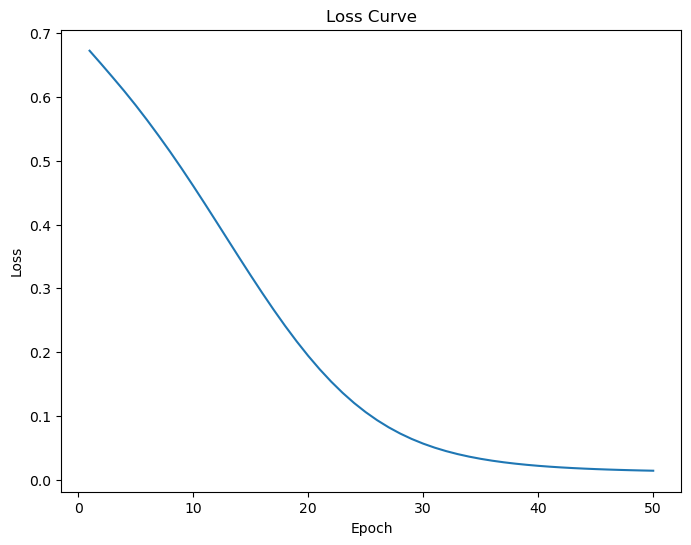

In [33]:
# Define your GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, h_feats, allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = F.relu(self.conv2(g, h))
        return h

# Define the link prediction model
class LinkPredictor(nn.Module):
    def __init__(self, in_features):
        super(LinkPredictor, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(2 * in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 1))  # Output: 1 class for binary classification

    def forward(self, emb1, emb2):
        combined_embeddings = torch.cat([emb1, emb2], dim=1)
        predictions = self.predictor(combined_embeddings)
        return predictions

# Model initialization
gcn = GCN(in_feats=feature_size, h_feats=64).to(device)  # Adjust hidden features size as needed
link_predictor = LinkPredictor(in_features=64).to(device)

# Define loss and optimizer
loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(gcn.parameters()) + list(link_predictor.parameters()), lr=0.01)

# Training loop
num_epochs = 50
loss_values = []  # Store loss values for plotting
for epoch in range(num_epochs):
    gcn.train()
    link_predictor.train()
    optimizer.zero_grad()

    # Forward pass through GCN and Link Predictor
    embeddings = gcn(g, g.ndata['feat'])
    pred = link_predictor(embeddings[edges_src_train], embeddings[edges_dst_train])
    loss = loss_func(pred.squeeze(), labels_train)
    loss_values.append(loss.item())  # Store the loss for plotting

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [34]:
with torch.no_grad():
    # Generate embeddings for all nodes
    embeddings = gcn(g, g.ndata['feat'])

    # Predict links for all test edges
    pred = link_predictor(embeddings[edges_src_test], embeddings[edges_dst_test])

    # Apply a sigmoid function to get probabilities
    pred_probs = torch.sigmoid(pred.squeeze())

    # Determine predictions using a threshold (e.g., 0.5)
    predicted_labels = (pred_probs > 0.5).float()

    # Print the predicted labels and ground truth labels
    print('Predicted Labels (Probabilities > 0.5):', predicted_labels)
    print('Ground Truth Labels:', labels_test)

    # Compute the accuracy
    correct_predictions = (predicted_labels == labels_test).sum().item()
    total_predictions = labels_test.size(0)
    accuracy = correct_predictions / total_predictions
    print(f'Accuracy: {accuracy * 100:.2f}%')

Predicted Labels (Probabilities > 0.5): tensor([0., 0., 0.,  ..., 0., 0., 0.])
Ground Truth Labels: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Accuracy: 99.87%


In [35]:
# Assuming you already have edges_src_test, edges_dst_test, and the trained models: gcn, link_predictor

gcn.eval()
link_predictor.eval()

with torch.no_grad():
    embeddings = gcn(g, g.ndata['feat'])
    outputs = link_predictor(embeddings[edges_src_test], embeddings[edges_dst_test]).squeeze()
    probabilities = torch.sigmoid(outputs)


AUC: It measures the ability of the model to discriminate between the classes:

In [36]:
from sklearn.metrics import roc_auc_score

# Convert tensors to CPU if necessary and calculate AUC
auc_score = roc_auc_score(labels_test.cpu(), probabilities.cpu())
print(f'AUC Score: {auc_score:.4f}')


AUC Score: 0.5000


MRR: MRR is an evaluation metric for ranking predictions. It is the average of the reciprocal ranks of results for a sample of queries Q:

In [37]:
def mean_reciprocal_rank(predictions, labels):
    ranks = []
    for i, label in enumerate(labels):
        if label == 1:  # Assuming '1' denotes the positive class
            sorted_indices = torch.argsort(predictions, descending=True)
            rank = (sorted_indices == i).nonzero(as_tuple=True)[0].item() + 1
            ranks.append(1.0 / rank)
    return np.mean(ranks)

mrr_score = mean_reciprocal_rank(probabilities, labels_test)
print(f'MRR Score: {mrr_score:.4f}')


MRR Score: 0.0000


Here's the updated code incorporating the suggestions for adjusting the model architecture, using binary cross-entropy loss, performing hyperparameter tuning, validating the model, and analyzing the data distribution

In this updated code:

We analyze the data distribution by counting the number of clicked and not-clicked articles and print the class weights to address class imbalance.

We split the data into train, validation, and test sets for better model evaluation and validation.

We define an updated GCN model that allows for a variable number of layers and hidden features.

We perform hyperparameter tuning by iterating over different combinations of hidden features, number of layers, and learning rates. We evaluate the model on the validation set and select the best hyperparameters based on the validation AUC score.

We train the model using the best hyperparameters and evaluate its performance on the test set.

We use binary cross-entropy loss with class weights to address class imbalance during training.

We add dropout regularization to the link predictor to prevent overfitting.

In [27]:
# Assuming df_articles, df_history, and df_behaviors are pandas DataFrames that are already available
article_ids = df_articles['article_id'].unique()
user_ids = df_history['user_id'].unique()

# Map article and user IDs to continuous indices for DGL
article_to_index = {article_id: i for i, article_id in enumerate(article_ids)}
user_to_index = {user_id: len(article_ids) + i for i, user_id in enumerate(user_ids)}

import random

# Prepare source and destination node lists for edges with downsampling not clicked cases
downsampling_factor = 0.1  # Keep 10% of not clicked cases
edges_src = []
edges_dst = []
labels = []

for user_id in user_ids:
    user_idx = user_to_index[user_id]
    clicked_articles = set(df_behaviors[df_behaviors['user_id'] == user_id]['article_ids_clicked'].explode())

    for article_id in article_ids:
        article_idx = article_to_index[article_id]
        is_clicked = article_id in clicked_articles
        if is_clicked or random.random() < downsampling_factor:  # Only add not clicked with 10% probability
            edges_src.append(user_idx)
            edges_dst.append(article_idx)
            labels.append(int(is_clicked))

# Convert edges and labels lists to tensors
edges_src = torch.tensor(edges_src, dtype=torch.long)
edges_dst = torch.tensor(edges_dst, dtype=torch.long)
labels = torch.tensor(labels, dtype=torch.float32)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if 'node_features' is defined
num_nodes = len(article_ids) + len(user_ids)
try:
    # Check if 'node_features' is properly shaped
    if node_features.shape[0] != num_nodes:
        print("Incorrect node_features shape. Adjusting...")
        feature_size = node_features.shape[1]
        node_features = torch.randn(num_nodes, feature_size)  # Adjust feature_size as needed
        node_features = node_features.to(device)
except NameError:
    # If 'node_features' is not defined, define it
    print("node_features is not defined. Creating new features...")
    feature_size = 10  # Example feature size, define as appropriate
    node_features = torch.randn(num_nodes, feature_size)
    node_features = node_features.to(device)

# Split data into train and test sets
data = list(zip(edges_src.tolist(), edges_dst.tolist(), labels.tolist()))
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Unpack the split data
edges_src_train, edges_dst_train, labels_train = zip(*train_data)
edges_src_test, edges_dst_test, labels_test = zip(*test_data)

# Convert back to tensors
edges_src_train = torch.tensor(edges_src_train, dtype=torch.long).to(device)
edges_dst_train = torch.tensor(edges_dst_train, dtype=torch.long).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float32).to(device)
edges_src_test = torch.tensor(edges_src_test, dtype=torch.long).to(device)
edges_dst_test = torch.tensor(edges_dst_test, dtype=torch.long).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float32).to(device)

# Creating the graph with the correct number of nodes
g = dgl.graph((edges_src_train, edges_dst_train), num_nodes=num_nodes).to(device)
g.ndata['feat'] = node_features  # Assign features to nodes

# Confirm feature assignment
print("Features assigned correctly. Feature shape:", g.ndata['feat'].shape)

Features assigned correctly. Feature shape: torch.Size([13367, 103])


In [31]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import class_weight

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume previous data loading and feature setting is done here...
feature_size = node_features.shape[1]  # Assuming node_features is defined
num_nodes = node_features.shape[0]

# Calculate class weights for imbalanced data handling
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels.numpy()), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights = class_weights[labels_train.long()]

print(class_weights)

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Unpack and convert data tuples to tensors and send to device
edges_src_train, edges_dst_train, labels_train = zip(*train_data)
edges_src_val, edges_dst_val, labels_val = zip(*val_data)
edges_src_test, edges_dst_test, labels_test = zip(*test_data)

edges_src_train = torch.tensor(edges_src_train, dtype=torch.long).to(device)
edges_dst_train = torch.tensor(edges_dst_train, dtype=torch.long).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float32).to(device)
edges_src_val = torch.tensor(edges_src_val, dtype=torch.long).to(device)
edges_dst_val = torch.tensor(edges_dst_val, dtype=torch.long).to(device)
labels_val = torch.tensor(labels_val, dtype=torch.float32).to(device)
edges_src_test = torch.tensor(edges_src_test, dtype=torch.long).to(device)
edges_dst_test = torch.tensor(edges_dst_test, dtype=torch.long).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float32).to(device)

# Debug: Print the shapes of the data tensors
print(f"edges_src_train shape: {edges_src_train.shape}")
print(f"edges_dst_train shape: {edges_dst_train.shape}")
print(f"labels_train shape: {labels_train.shape}")
print(f"edges_src_val shape: {edges_src_val.shape}")
print(f"edges_dst_val shape: {edges_dst_val.shape}")
print(f"labels_val shape: {labels_val.shape}")
print(f"edges_src_test shape: {edges_src_test.shape}")
print(f"edges_dst_test shape: {edges_dst_test.shape}")
print(f"labels_test shape: {labels_test.shape}")

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList([GraphConv(in_feats, h_feats, allow_zero_in_degree=True)])
        for _ in range(1, num_layers):
            self.layers.append(GraphConv(h_feats, h_feats, allow_zero_in_degree=True))

    def forward(self, g, in_feat):
        h = in_feat
        for layer in self.layers:
            h = F.relu(layer(g, h))
        return h

# Define the Link Predictor
class LinkPredictor(nn.Module):
    def __init__(self, in_features):
        super(LinkPredictor, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(2 * in_features, in_features),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features, 1)
        )

    def forward(self, emb1, emb2):
        combined_embeddings = torch.cat([emb1, emb2], dim=1)
        return self.predictor(combined_embeddings)

# Initialize models
gcn = GCN(feature_size, 128, 2).to(device)
link_predictor = LinkPredictor(128).to(device)
#loss_func = nn.BCEWithLogitsLoss(weight=class_weights.view(-1, 1))
loss_func = nn.BCEWithLogitsLoss(weight=class_weights.view(-1))
optimizer = torch.optim.Adam(list(gcn.parameters()) + list(link_predictor.parameters()), lr=0.01)

# Training loop with diagnostics and immediate shape checking
num_epochs = 50
for epoch in range(num_epochs):
    gcn.train()
    link_predictor.train()
    optimizer.zero_grad()

    embeddings = gcn(g, g.ndata['feat'])
    pred_train = link_predictor(embeddings[edges_src_train], embeddings[edges_dst_train])
    pred_train = pred_train.squeeze()  # Adjust the prediction tensor to remove extra dimension
    pred_train = pred_train.view(-1)

    # Debug: Print the shapes of the embeddings and predictions
    print(f"Epoch {epoch+1}:")
    print(f"Shape of embeddings: {embeddings.shape}")
    print(f"Shape of predictions: {pred_train.shape}")
    print(f"Shape of labels: {labels_train.shape}")

    # Debug: Print the unique values and counts of labels_train
    print(f"Unique values in labels_train: {torch.unique(labels_train)}")
    print(f"Counts of unique values in labels_train: {torch.bincount(labels_train.long())}")

    # Ensure the shapes are correct before calculating the loss
    if pred_train.shape != labels_train.shape:
        print(f"Shape mismatch detected. Predictions shape: {pred_train.shape}, Labels shape: {labels_train.shape}")
        continue  # Skip this epoch or handle the mismatch more gracefully

    try:
        loss = loss_func(pred_train, labels_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item()}")
    except RuntimeError as e:
        print(f"An error occurred: {e}")

# Validation loop to check performance on unseen data
gcn.eval()
link_predictor.eval()
with torch.no_grad():
    embeddings_val = gcn(g, g.ndata['feat'])
    pred_val = link_predictor(embeddings_val[edges_src_val], embeddings_val[edges_dst_val])
    pred_val = pred_val.squeeze()  # Ensure tensor shape is correct for comparison

    if pred_val.shape != labels_val.shape:
        print(f"Validation phase shape mismatch: {pred_val.shape} vs {labels_val.shape}")

    pred_probs_val = torch.sigmoid(pred_val)
    auc_val = roc_auc_score(labels_val.cpu().numpy(), pred_probs_val.cpu().numpy())
    print(f"Validation AUC: {auc_val:.4f}")

# Test loop to evaluate final model performance
with torch.no_grad():
    embeddings_test = gcn(g, g.ndata['feat'])
    pred_test = link_predictor(embeddings_test[edges_src_test], embeddings_test[edges_dst_test])
    pred_test = pred_test.squeeze()  # Adjust tensor shape

    if pred_test.shape != labels_test.shape:
        print(f"Test phase shape mismatch: {pred_test.shape} vs {labels_test.shape}")

    pred_probs_test = torch.sigmoid(pred_test)
    test_auc = roc_auc_score(labels_test.cpu().numpy(), pred_probs_test.cpu().numpy())
    print(f"Test AUC: {test_auc:.4f}")

tensor([0.5065, 0.5065, 0.5065,  ..., 0.5065, 0.5065, 0.5065])
edges_src_train shape: torch.Size([1137788])
edges_dst_train shape: torch.Size([1137788])
labels_train shape: torch.Size([1137788])
edges_src_val shape: torch.Size([379263])
edges_dst_val shape: torch.Size([379263])
labels_val shape: torch.Size([379263])
edges_src_test shape: torch.Size([379263])
edges_dst_test shape: torch.Size([379263])
labels_test shape: torch.Size([379263])
Epoch 1:
Shape of embeddings: torch.Size([13367, 128])
Shape of predictions: torch.Size([1137788])
Shape of labels: torch.Size([1137788])
Unique values in labels_train: tensor([0., 1.])
Counts of unique values in labels_train: tensor([1123161,   14627])
Epoch 2:
Shape of embeddings: torch.Size([13367, 128])
Shape of predictions: torch.Size([1137788])
Shape of labels: torch.Size([1137788])
Unique values in labels_train: tensor([0., 1.])
Counts of unique values in labels_train: tensor([1123161,   14627])
Epoch 3:
Shape of embeddings: torch.Size([13367,

Here are the main changes made to the code:

SMOTE oversampling is applied to the node features and labels to handle class imbalance before splitting the data into train, validation, and test sets.

The hidden feature size of the GCN model is increased to 256, and the number of layers is increased to 3 to enhance the model's capacity.
The learning rate of the optimizer is reduced to 0.001, and weight decay regularization is added with a factor of 1e-5 to prevent overfitting.

The number of training epochs is increased to 100 to give the model more opportunities to learn.

Validation AUC is calculated and printed every 10 epochs to monitor the model's performance on unseen data during training.

In [35]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv, GATConv, SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume previous data loading and feature setting is done here...
feature_size = node_features.shape[1]  # Assuming node_features is defined
num_nodes = node_features.shape[0]

# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Unpack and convert data tuples to tensors and send to device
edges_src_train, edges_dst_train, labels_train = zip(*train_data)
edges_src_val, edges_dst_val, labels_val = zip(*val_data)
edges_src_test, edges_dst_test, labels_test = zip(*test_data)

edges_src_train = torch.tensor(edges_src_train, dtype=torch.long).to(device)
edges_dst_train = torch.tensor(edges_dst_train, dtype=torch.long).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float32).to(device)
edges_src_val = torch.tensor(edges_src_val, dtype=torch.long).to(device)
edges_dst_val = torch.tensor(edges_dst_val, dtype=torch.long).to(device)
labels_val = torch.tensor(labels_val, dtype=torch.float32).to(device)
edges_src_test = torch.tensor(edges_src_test, dtype=torch.long).to(device)
edges_dst_test = torch.tensor(edges_dst_test, dtype=torch.long).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float32).to(device)

# Apply SMOTE oversampling to handle class imbalance in the training data
smote = SMOTE(random_state=42)
edges_train_resampled, labels_train_resampled = smote.fit_resample(
    np.column_stack((edges_src_train.cpu().numpy(), edges_dst_train.cpu().numpy())),
    labels_train.cpu().numpy()
)
edges_src_train = torch.tensor(edges_train_resampled[:, 0], dtype=torch.long).to(device)
edges_dst_train = torch.tensor(edges_train_resampled[:, 1], dtype=torch.long).to(device)
labels_train = torch.tensor(labels_train_resampled, dtype=torch.float32).to(device)

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList([GraphConv(in_feats, h_feats, allow_zero_in_degree=True)])
        for _ in range(1, num_layers):
            self.layers.append(GraphConv(h_feats, h_feats, allow_zero_in_degree=True))

    def forward(self, g, in_feat):
        h = in_feat
        for layer in self.layers:
            h = F.relu(layer(g, h))
        return h

# Define the Link Predictor
class LinkPredictor(nn.Module):
    def __init__(self, in_features):
        super(LinkPredictor, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(2 * in_features, in_features),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features, 1)
        )

    def forward(self, emb1, emb2):
        combined_embeddings = torch.cat([emb1, emb2], dim=1)
        return self.predictor(combined_embeddings)

# Initialize models
gcn = GCN(feature_size, 256, 3).to(device)  # Increase hidden feature size and num_layers
link_predictor = LinkPredictor(256).to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(gcn.parameters()) + list(link_predictor.parameters()), lr=0.001, weight_decay=1e-5)

# Training loop with diagnostics and immediate shape checking
num_epochs = 100  # Increase the number of epochs
for epoch in range(num_epochs):
    gcn.train()
    link_predictor.train()
    optimizer.zero_grad()

    embeddings = gcn(g, g.ndata['feat'])
    pred_train = link_predictor(embeddings[edges_src_train], embeddings[edges_dst_train])
    pred_train = pred_train.squeeze()  # Adjust the prediction tensor to remove extra dimension
    pred_train = pred_train.view(-1)

    loss = loss_func(pred_train, labels_train)
    loss.backward()
    optimizer.step()

    #if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")

    # Validation loop to check performance on unseen data
    if (epoch + 1) % 10 == 0:
        gcn.eval()
        link_predictor.eval()
        with torch.no_grad():
            embeddings_val = gcn(g, g.ndata['feat'])
            pred_val = link_predictor(embeddings_val[edges_src_val], embeddings_val[edges_dst_val])
            pred_val = pred_val.squeeze()  # Ensure tensor shape is correct for comparison
            pred_probs_val = torch.sigmoid(pred_val)
            auc_val = roc_auc_score(labels_val.cpu().numpy(), pred_probs_val.cpu().numpy())
            print(f"Validation AUC at Epoch {epoch+1}: {auc_val:.4f}")

# Test loop to evaluate final model performance
gcn.eval()
link_predictor.eval()
with torch.no_grad():
    embeddings_test = gcn(g, g.ndata['feat'])
    pred_test = link_predictor(embeddings_test[edges_src_test], embeddings_test[edges_dst_test])
    pred_test = pred_test.squeeze()  # Adjust tensor shape
    pred_probs_test = torch.sigmoid(pred_test)
    test_auc = roc_auc_score(labels_test.cpu().numpy(), pred_probs_test.cpu().numpy())
    print(f"Test AUC: {test_auc:.4f}")

Epoch 1: Loss = 0.6934959888458252
Epoch 2: Loss = 0.6934020519256592
Epoch 3: Loss = 0.6933240294456482
Epoch 4: Loss = 0.6932592988014221
Epoch 5: Loss = 0.6932110786437988
Epoch 6: Loss = 0.6931801438331604
Epoch 7: Loss = 0.6931565403938293
Epoch 8: Loss = 0.6931541562080383
Epoch 9: Loss = 0.6931561827659607
Epoch 10: Loss = 0.6931588053703308
Validation AUC at Epoch 10: 0.5000
Epoch 11: Loss = 0.6931687593460083
Epoch 12: Loss = 0.6931816339492798
Epoch 13: Loss = 0.6931830048561096
Epoch 14: Loss = 0.6931900382041931
Epoch 15: Loss = 0.6931864023208618
Epoch 16: Loss = 0.6931809782981873
Epoch 17: Loss = 0.6931753158569336
Epoch 18: Loss = 0.6931683421134949
Epoch 19: Loss = 0.6931580901145935
Epoch 20: Loss = 0.6931594014167786
Validation AUC at Epoch 20: 0.5000
Epoch 21: Loss = 0.6931518912315369
Epoch 22: Loss = 0.6931527853012085
Epoch 23: Loss = 0.6931509375572205
Epoch 24: Loss = 0.6931538581848145
Epoch 25: Loss = 0.6931565403938293
Epoch 26: Loss = 0.6931577324867249
Epo